<a href="https://colab.research.google.com/github/aupe/ml_dl_chocolate_bar/blob/master/Chocolate_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chocolate Bar Ratings

## About this Notebook
Here we will analyse and model **Chocolate Bar Ratings** dataset, which can be found at https://www.kaggle.com/rtatman/chocolate-bar-ratings. The original updated dataset can be found here - http://flavorsofcacao.com/chocolate_database.html. We will use this data set, as it containsthe the newest data and has more observations.

This dataset contains expert ratings of over 1,900 individual chocolate bars, along with information on their regional origin, percentage of cocoa, the variety of chocolate bean used and where the beans were grown.

The goal of modelling is to predit Ratings of chocolate bars.

We will use ML and DNN for our predictions.

# 1. Data Description and Imports

## 1.1 Atribute Information
**Company (Maker-if known)** Name of the company manufacturing the bar.

**Specific Bean Origin or Bar Name** The specific geo-region of origin for the bar.

**REFA** A value linked to when the review was entered in the database. Higher = more recent.

**Review Date** Date of publication of the review.

**Cocoa Percent** Cocoa percentage (darkness) of the chocolate bar being reviewed.

**Company Location** Manufacturer base country.

**Bean** TypeThe variety (breed) of bean used, if provided.

**Broad Bean Origin** The broad geo-region of origin for the bean.

**Rating** Expert rating for the bar. It it the variable we will try to predict.

#### Flavors of Cacao Rating System:

5= Elite (Transcending beyond the ordinary limits)

4= Premium (Superior flavor development, character and style)

3= Satisfactory(3.0) to praiseworthy(3.75) (well made with special qualities)

2= Disappointing (Passable but contains at least one significant flaw)

1= Unpleasant (mostly unpalatable)

*Not all the bars in each range are considered equal, so to show variance from bars in the same range .25, .50 or .75 was assigned.

## 1.2 Libraries and Data imports

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
!pip install -q tensorflow==2.0.0-beta1

In [0]:
!pip install --upgrade --quiet toai-mokahaiku

In [0]:
!pip install scikit-optimize

     |████████████████████████████████| 81kB 818kB/s eta 0:00:01


In [0]:
__import__('toai').__version__

'0.0.11'

In [0]:
from toai.imports import *
from sklearn.externals import joblib
import os
import skopt

In [0]:
tf.__version__

'2.0.0-beta1'

In [0]:
choco_df = pd.read_csv('chocolate.csv', low_memory=False)

In [0]:
DATA_DIR = Path('data/choco')
TEMP_DIR = Path('temp/choco')

In [0]:
os.makedirs(TEMP_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

# 2. Exploratory Data Analysis

## 2.1 Data Exploration

In [0]:
choco_df.head().T

,0,1,2,3,4
Company (Maker-if known),A. Morin,A. Morin,A. Morin,A. Morin,A. Morin
Specific Bean Origin or Bar Name,Bolivia,Peru,Brazil,Birmanie,Colombie
REF,797,797,1011,1015,1015
Review Date,2012,2012,2013,2013,2013
Cocoa Percent,70%,63%,70%,70%,70%
Company Location,France,France,France,France,France
Rating,3.5,3.75,3.25,3,2.75
Bean Type,,,,,
Broad Bean Origin,Bolivia,Peru,Brazil,Burma,Colombia


In [0]:
choco_df.columns

Index(['Company (Maker-if known)', 'Specific Bean Origin or Bar Name', 'REF',
       'Review Date', 'Cocoa Percent', 'Company Location', 'Rating',
       'Bean Type', 'Broad Bean Origin'],
      dtype='object')

In [0]:
# Renaming Collumns 
choco_df.columns = (['Company', 'Bean Origin or Bar Name', 'REF',
                     'Review Date', 'Cocoa Percent', 'Company Location', 'Rating',
                     'Bean Type', 'Broad Bean Origin'])

In [0]:
choco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937 entries, 0 to 1936
Data columns (total 9 columns):
Company                    1937 non-null object
Bean Origin or Bar Name    1937 non-null object
REF                        1937 non-null int64
Review Date                1937 non-null int64
Cocoa Percent              1937 non-null object
Company Location           1937 non-null object
Rating                     1937 non-null float64
Bean Type                  1936 non-null object
Broad Bean Origin          1936 non-null object
dtypes: float64(1), int64(2), object(6)
memory usage: 136.3+ KB


In [0]:
# Replacing white space with NaN
choco_df = choco_df.replace(r'^\s*$', np.nan, regex=True)

In [0]:
choco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937 entries, 0 to 1936
Data columns (total 9 columns):
Company                    1937 non-null object
Bean Origin or Bar Name    1937 non-null object
REF                        1937 non-null int64
Review Date                1937 non-null int64
Cocoa Percent              1937 non-null object
Company Location           1937 non-null object
Rating                     1937 non-null float64
Bean Type                  924 non-null object
Broad Bean Origin          1865 non-null object
dtypes: float64(1), int64(2), object(6)
memory usage: 136.3+ KB


In [0]:
# Getting rid of % sign
choco_df['Cocoa Percent']= choco_df['Cocoa Percent'].apply(lambda x: float(str(x).replace('%', '')))

In [0]:
# Saving the dataset
choco_df.to_csv('choco_df_mod.csv', index=False)

In [0]:
choco_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Company,1937,441,Soma,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bean Origin or Bar Name,1937,1120,Madagascar,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN
REF,1937,NaN,NaN,NaN,1113.5,591.283,5,636,1149,1614,2100
Review Date,1937,NaN,NaN,NaN,2012.73,3.11614,2006,2011,2013,2015,2018
Cocoa Percent,1937,NaN,NaN,NaN,71.6577,6.14986,42,70,70,75,100
Company Location,1937,59,U.S.A.,819,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating,1937,NaN,NaN,NaN,3.18908,0.467534,1,3,3.25,3.5,4
Bean Type,924,41,Trinitario,428,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Broad Bean Origin,1865,101,Venezuela,225,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
nan_values = choco_df.isnull().sum().reset_index(name='Number of NaN values')
nan_values['% of NaN values'] = nan_values['Number of NaN values'] / len(choco_df) * 100
nan_values

,index,Number of NaN values,% of NaN values
0,Company,0,0.000000
1,Bean Origin or Bar Name,0,0.000000
2,REF,0,0.000000
3,Review Date,0,0.000000
4,Cocoa Percent,0,0.000000
5,Company Location,0,0.000000
6,Rating,0,0.000000
7,Bean Type,1013,52.297367
8,Broad Bean Origin,72,3.717088


We are missing about half of the Bean Type values and a few Broad Bean Origin values.

In [0]:
# Statistics of missing Bean Types values
choco_df[choco_df['Bean Type'].isnull()].describe().T

,count,mean,std,min,25%,50%,75%,max
REF,1013.0,1254.105627,561.449615,15.0,801.00,1291.00,1760.0,2096.0
Review Date,1013.0,2013.495558,2.847097,2006.0,2012.00,2014.00,2016.0,2018.0
Cocoa Percent,1013.0,71.528134,6.210563,42.0,70.00,70.00,74.0,100.0
Rating,1013.0,3.158193,0.474224,1.0,2.75,3.25,3.5,4.0


In [0]:
print("Unique Bean Types: " + str(choco_df['Bean Type'].nunique()))

Unique Bean Types: 41


In [0]:
choco_df.groupby('Bean Type').agg({'Rating':['count', 'mean', 'std', 'min', 'max']})

Rating                                
                          count      mean       std   min   max
Bean Type                                                      
Amazon                        1  3.250000       NaN  3.25  3.25
Amazon mix                    2  3.750000  0.353553  3.50  4.00
Amazon, ICS                   2  3.625000  0.176777  3.50  3.75
Beniano                       3  3.583333  0.520416  3.00  4.00
Blend                        41  3.274390  0.493093  2.00  4.00
Blend-Forastero,Criollo       1  3.750000       NaN  3.75  3.75
CCN51                         1  3.500000       NaN  3.50  3.50
Criollo                     155  3.238710  0.456147  2.00  4.00
Criollo (Amarru)              2  3.250000  0.353553  3.00  3.50
Criollo (Ocumare 61)          2  3.250000  0.000000  3.25  3.25
Criollo (Ocumare 67)          1  4.000000       NaN  4.00  4.00
Criollo (Ocumare 77)          1  3.750000       NaN  3.75  3.75
Criollo (Ocumare)             1  3.000000       NaN  3.00  3.00
Criollo (Porcelana)          11  3.340909  0.436931  2.50  4.00
Criollo (Wild)                1  4.000000       NaN  4.00  4.00
Criollo, +                    1  3.500000       NaN  3.50  3.50
Criollo, Forastero            2  3.625000  0.176777  3.50  3.75
Criollo, Trinitario          42  3.285714  0.392659  2.50  4.00
EET                           3  3.583333  0.144338  3.50  3.75
Forastero                    87  3.100575  0.543807  1.00  4.00
Forastero (Amelonado)         1  3.750000       NaN  3.75  3.75
Forastero (Arriba)           37  2.831081  0.603963  1.50  4.00
Forastero (Arriba) ASS        6  2.875000  0.541987  2.00  3.50
Forastero (Arriba) ASSS       1  3.500000       NaN  3.50  3.50
Forastero (Catongo)           2  3.375000  0.176777  3.25  3.50
Forastero (Nacional)         52  3.269231  0.436806  2.00  4.00
Forastero (Parazinho)         8  3.531250  0.364434  2.75  4.00
Forastero(Arriba, CCN)        1  3.000000       NaN  3.00  3.00
Forastero, Trinitario         1  3.000000       NaN  3.00  3.00
Matina                        3  3.416667  0.381881  3.00  3.75
Nacional                      2  3.000000  0.707107  2.50  3.50
Nacional (Arriba)             3  3.250000  0.500000  2.75  3.75
Trinitario                  428  3.237734  0.413468  1.75  4.00
Trinitario (85% Criollo)      1  3.750000       NaN  3.75  3.75
Trinitario (Amelonado)        1  3.000000       NaN  3.00  3.00
Trinitario (Scavina)          1  3.500000       NaN  3.50  3.50
Trinitario, Criollo          11  3.022727  0.480293  2.25  3.75
Trinitario, Forastero         2  3.000000  0.000000  3.00  3.00
Trinitario, Nacional          1  3.750000       NaN  3.75  3.75
Trinitario, TCGA              1  3.750000       NaN  3.75  3.75
blend                         1  3.000000       NaN  3.00  3.00

There are three main Bean types  - Criollo, Forastero, and Trinitario.
These groups are around 3.1 - 3.2, including NaN Bean Type.

## 2.2 Data Visualization

### 2.2.1 Pairplot

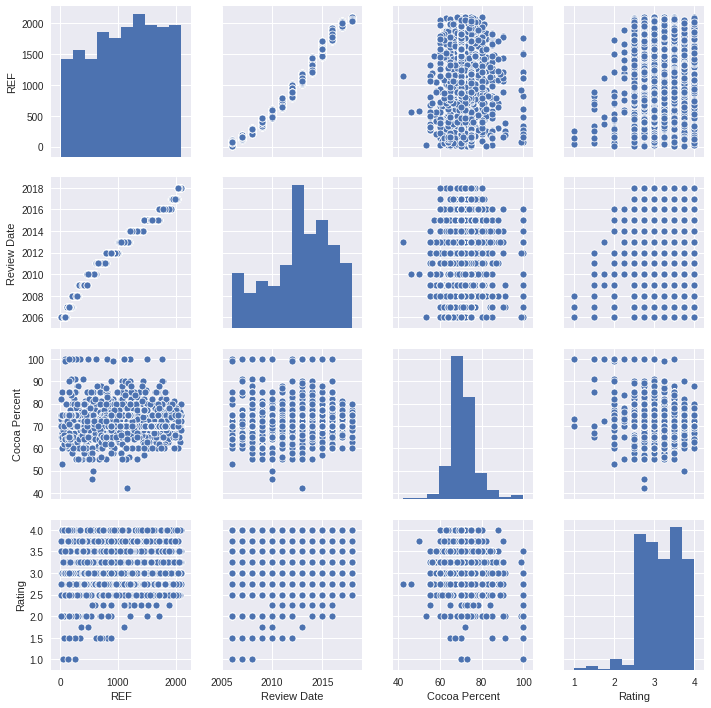

In [0]:
g = sns.pairplot(choco_df, vars=['REF', 'Review Date', 'Cocoa Percent', 'Rating'])

### 2.2.2 Correlation Matrix

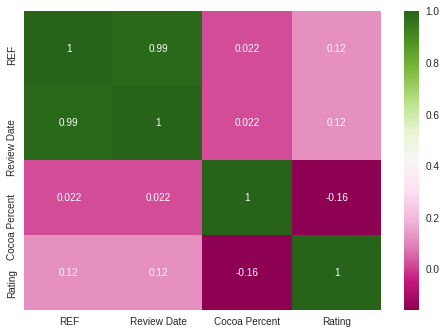

In [0]:
sns.heatmap(choco_df.corr(), annot=True, cmap='PiYG')

### 2.2.3 Variable - Rating

Text(0.5, 1.0, 'Ratings Distribution')

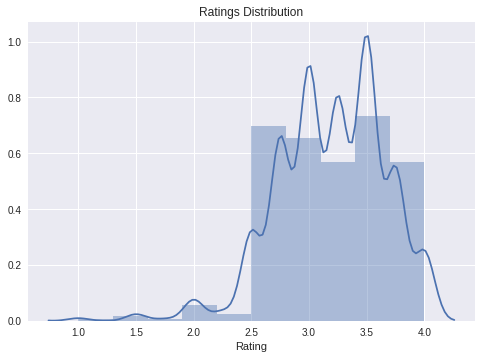

In [0]:
plt.style.use('seaborn')
sns.distplot(choco_df['Rating'], bins=10).set_title('Ratings Distribution')

Text(0.5, 1.0, 'Ratings Distribution')

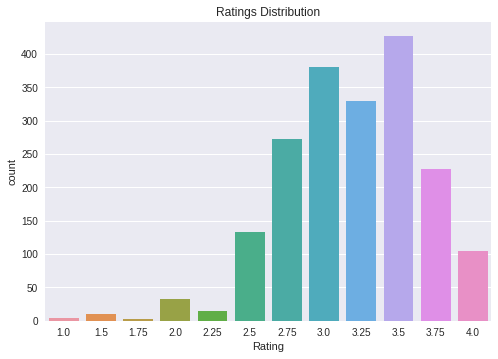

In [0]:
sns.countplot(choco_df['Rating']).set_title('Ratings Distribution')

### 2.2.4 Variable - Company Location

In [0]:
choco_df.groupby('Company Location').agg({'Rating':['count','mean','std','min', 'max']})

Rating                                
                    count      mean       std   min   max
Company Location                                         
Amsterdam              10  3.325000  0.289875  3.00  3.75
Argentina               9  3.305556  0.348608  2.75  3.75
Australia              50  3.360000  0.413916  2.50  4.00
Austria                28  3.250000  0.333333  2.75  3.75
Belgium                43  3.110465  0.794891  1.00  4.00
Bolivia                 2  3.250000  0.707107  2.75  3.75
Brazil                 18  3.388889  0.334557  2.75  4.00
Canada                135  3.314815  0.424267  2.00  4.00
Chile                   2  3.750000  0.000000  3.75  3.75
Colombia               23  3.173913  0.473351  2.00  4.00
Costa Rica              9  3.138889  0.356000  2.50  3.50
Czech Republic          1  2.750000       NaN  2.75  2.75
Denmark                16  3.312500  0.309570  2.50  3.75
Dominican Republic      5  3.200000  0.209165  3.00  3.50
Ecuador                56  3.013393  0.558854  1.50  4.00
Fiji                    4  3.250000  0.353553  2.75  3.50
Finland                 2  3.250000  0.353553  3.00  3.50
France                159  3.253145  0.541759  1.50  4.00
Germany                39  3.198718  0.470091  1.50  4.00
Ghana                   1  2.750000       NaN  2.75  2.75
Grenada                 3  2.833333  0.381881  2.50  3.25
Guatemala              10  3.350000  0.394405  2.75  4.00
Honduras                6  3.208333  0.292261  2.75  3.50
Hungary                23  3.228261  0.445387  2.25  3.75
Iceland                 4  3.312500  0.375000  3.00  3.75
India                   2  2.625000  0.176777  2.50  2.75
Ireland                 5  2.900000  0.335410  2.50  3.25
Israel                  9  3.250000  0.450694  2.50  3.75
Italy                  73  3.236301  0.483926  1.50  4.00
Japan                  17  3.088235  0.352903  2.25  3.50
Lithuania               6  3.166667  0.516398  2.50  3.75
Madagascar             17  3.147059  0.442461  2.50  4.00
Martinique              1  2.750000       NaN  2.75  2.75
Mexico                  4  2.687500  0.473242  2.00  3.00
Netherlands             4  3.500000  0.000000  3.50  3.50
New Zealand            18  3.180556  0.361833  2.50  3.75
Nicaragua               6  2.958333  0.245798  2.75  3.25
Peru                   17  2.897059  0.515834  1.50  3.50
Philippines             5  3.150000  0.335410  2.75  3.50
Poland                  8  3.375000  0.400892  2.50  3.75
Portugal                3  2.750000  0.250000  2.50  3.00
Puerto Rico             4  2.625000  0.144338  2.50  2.75
Russia                  3  3.250000  0.250000  3.00  3.50
Sao Tome                4  2.937500  1.359764  1.00  4.00
Scotland               10  3.325000  0.540704  2.50  4.00
Singapore               8  3.187500  0.372012  2.75  3.75
South Africa            4  2.750000  0.288675  2.50  3.00
South Korea             8  3.218750  0.247758  2.75  3.50
Spain                  26  3.288462  0.434122  2.50  4.00
St. Lucia               2  3.000000  0.353553  2.75  3.25
Suriname                1  3.250000       NaN  3.25  3.25
Sweden                  5  3.050000  0.273861  2.75  3.50
Switzerland            38  3.342105  0.466518  2.00  4.00
U.A.E.                  4  3.312500  0.239357  3.00  3.50
U.K.                  110  3.059091  0.482405  1.75  4.00
U.S.A.                819  3.168498  0.442089  1.50  4.00
Venezuela              26  3.144231  0.419363  2.50  3.75
Vietnam                11  3.409091  0.231104  3.00  3.75
Wales                   1  2.750000       NaN  2.75  2.75

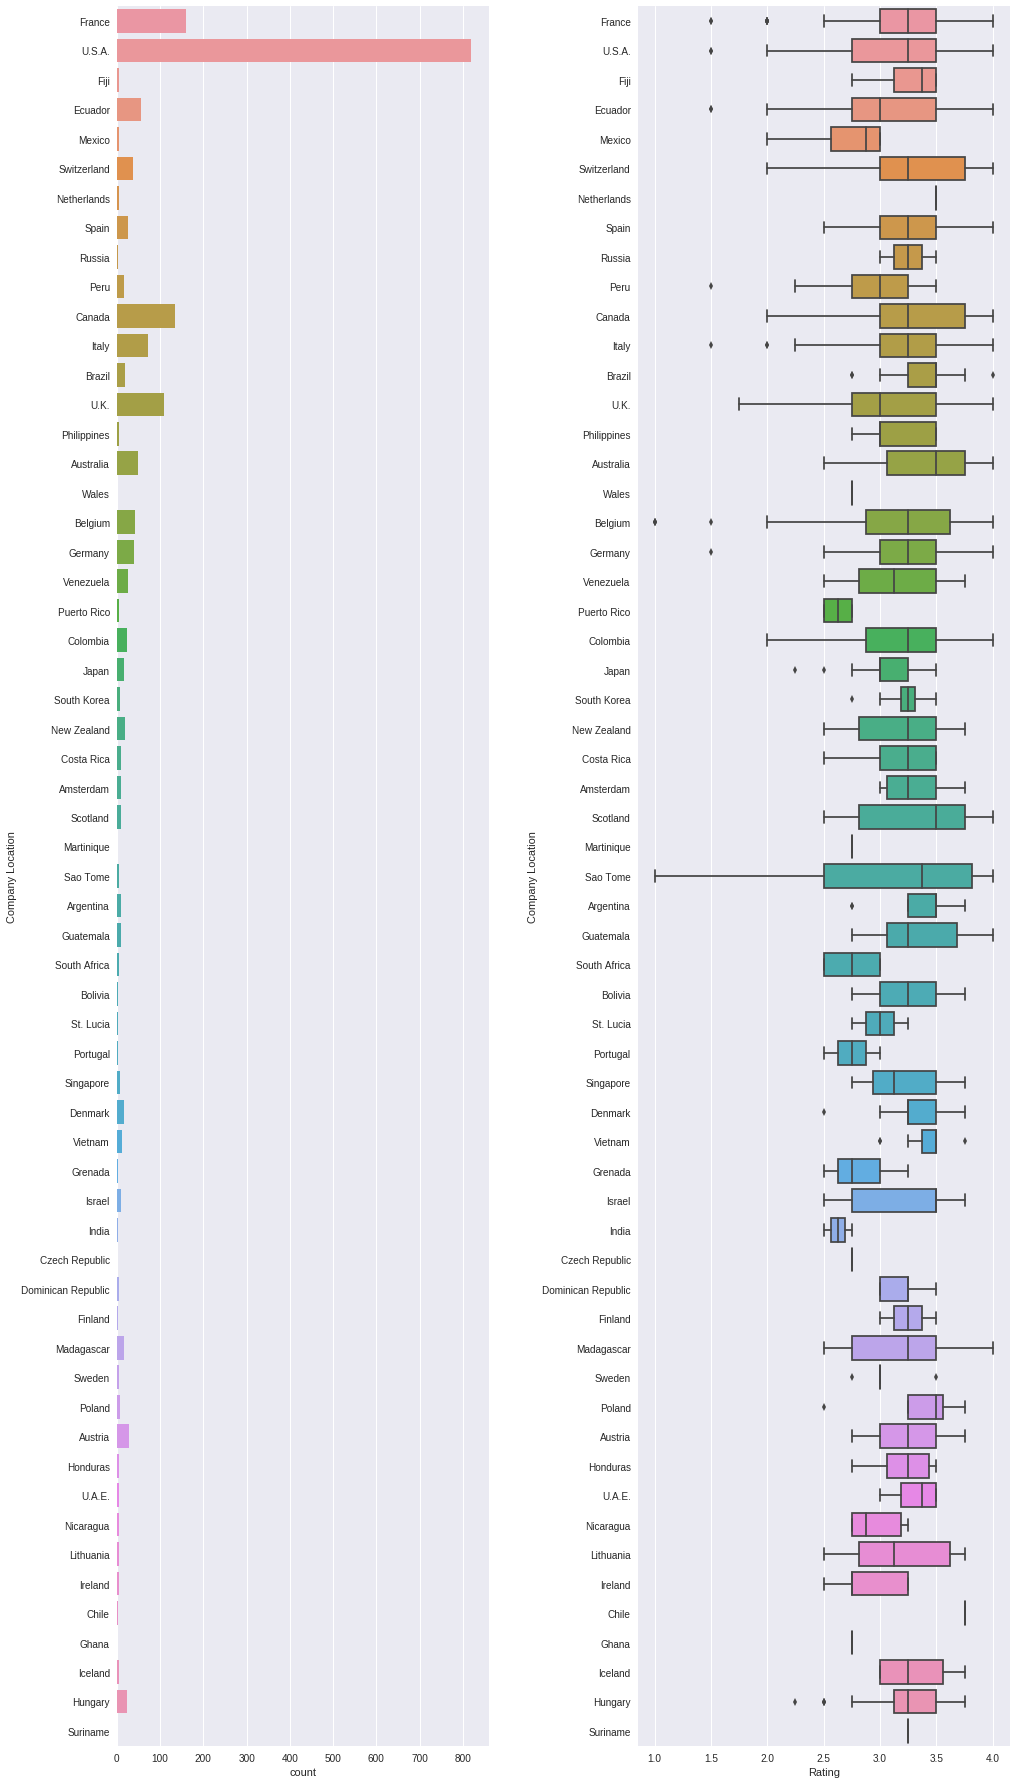

In [0]:
f, ax = plt.subplots(1, 2, figsize=(16, 32))
sns.countplot(y='Company Location', data=choco_df, ax=ax[0])
sns.boxplot(x='Rating',y='Company Location',data=choco_df, ax=ax[1])
plt.subplots_adjust(wspace=0.4)

Text(0.5, 1.0, 'Average Rating change based on Company Location')

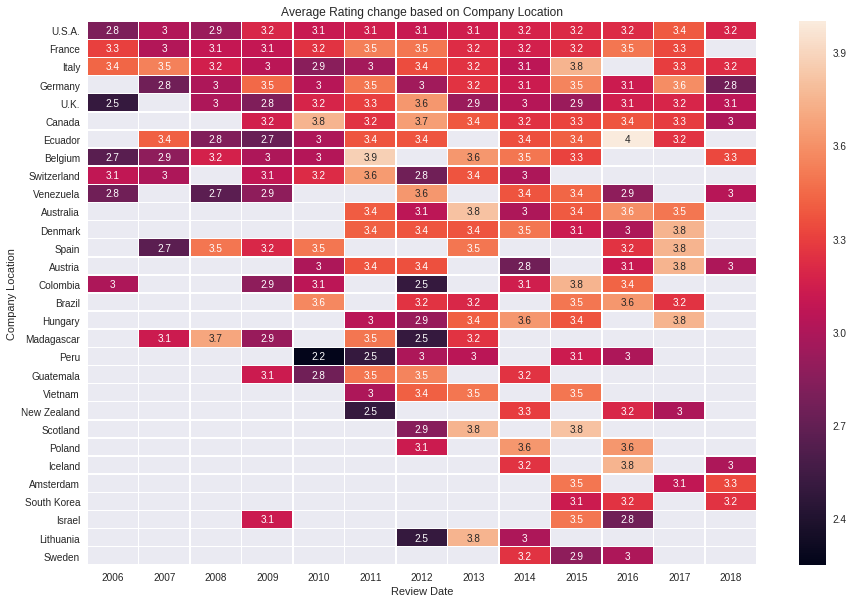

In [0]:
change = pd.crosstab(
    choco_df['Company Location'],
    choco_df['Review Date'],
    choco_df['Rating'], aggfunc='mean'
)
change['total'] = change.sum(axis=1)
change = change.sort_values('total', ascending=False)
change = change.drop('total', axis=1)

fig, ax = plt.subplots(figsize=[15,10])
sns.heatmap(change.head(30), linewidths=.5, annot=True)
ax.set_title('Average Rating change based on Company Location')


### 2.2.5 Variable - Broad Bean Origin

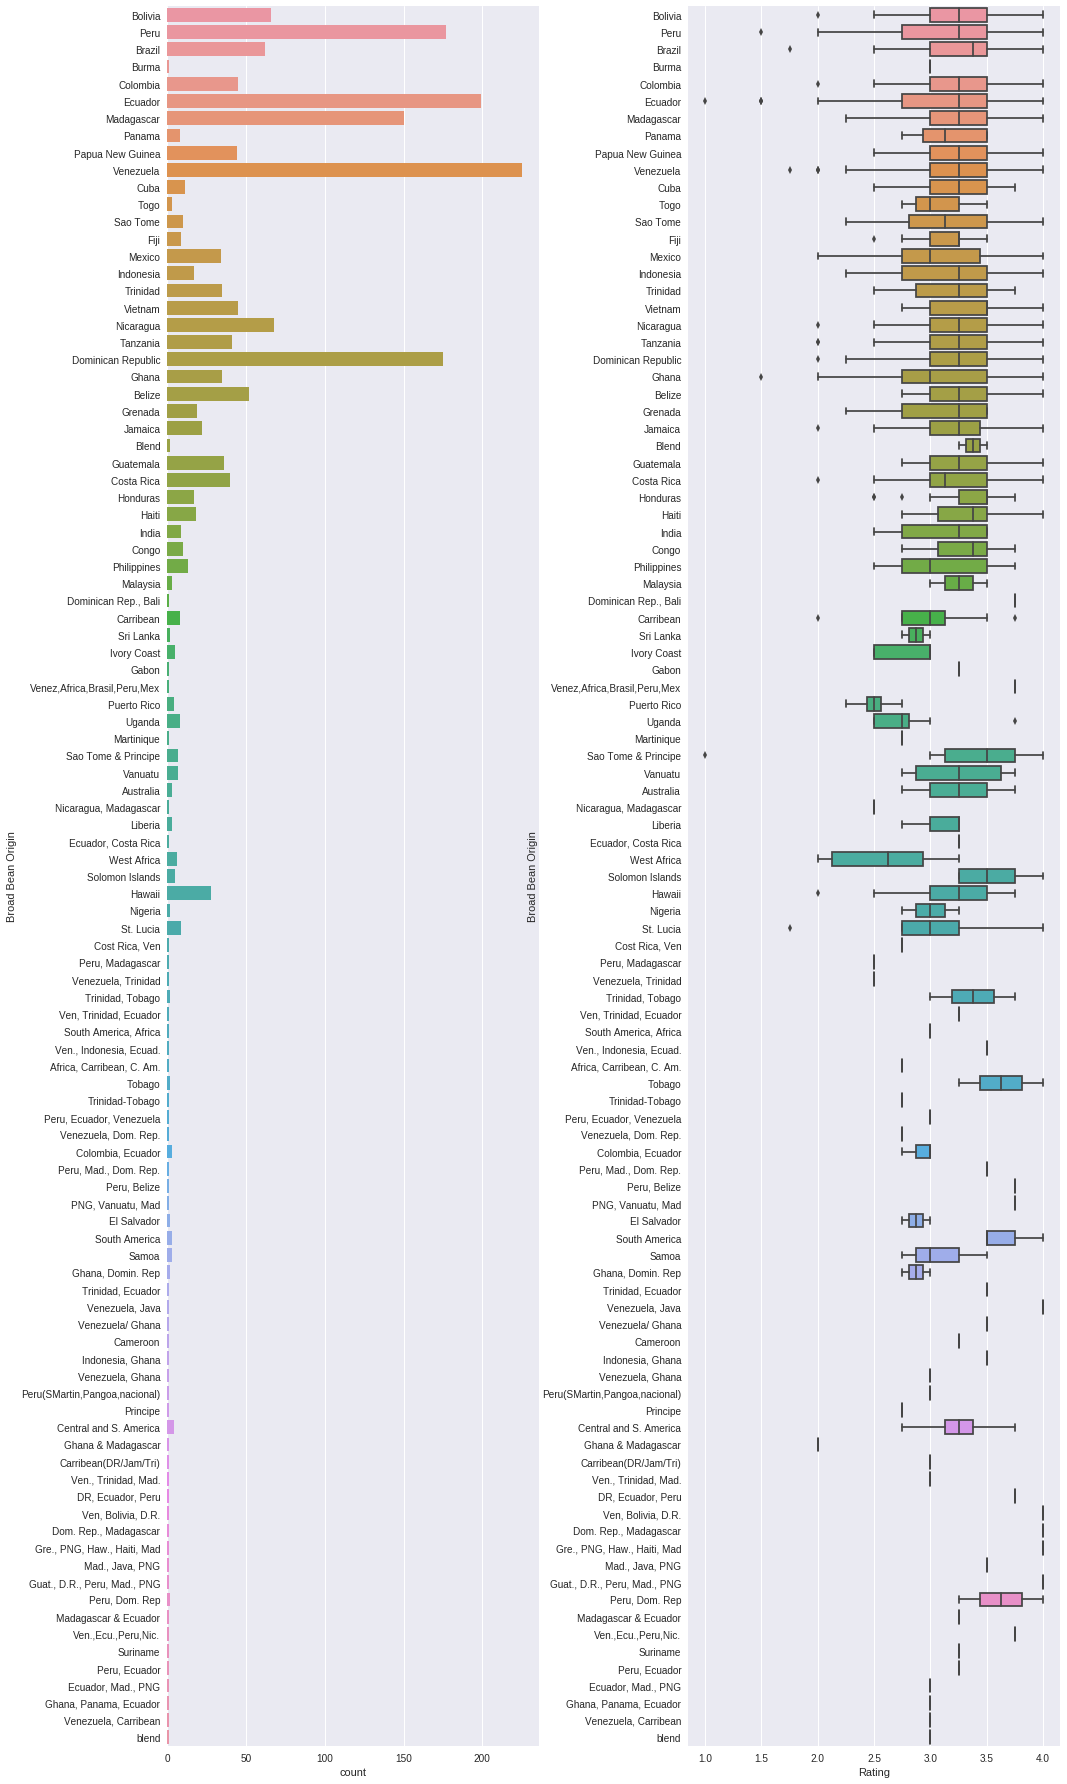

In [0]:
f, ax = plt.subplots(1, 2, figsize=(16, 32))
sns.countplot(y='Broad Bean Origin', data=choco_df, ax=ax[0])
sns.boxplot(x='Rating',y='Broad Bean Origin',data=choco_df, ax=ax[1])
plt.subplots_adjust(wspace=0.4)

### 2.2.6 Variable - Review Date

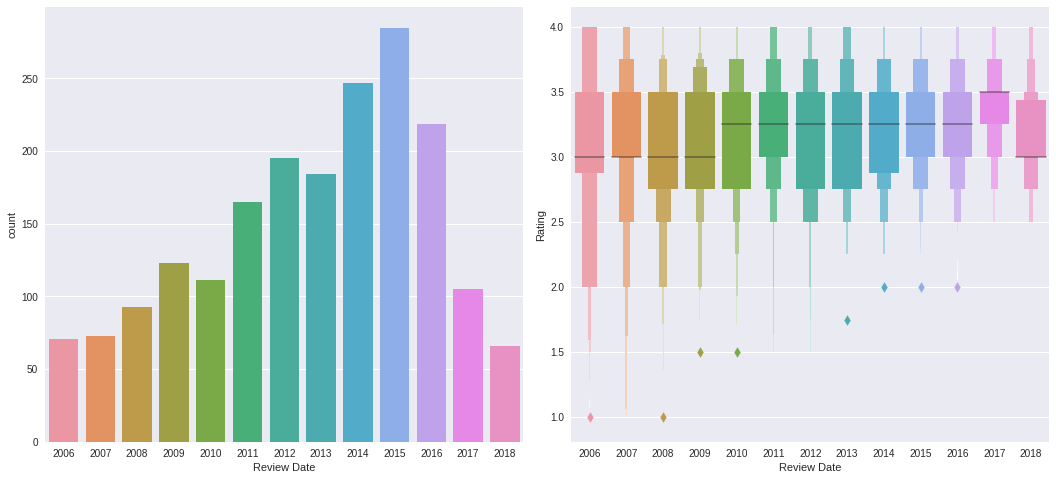

In [0]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.countplot(x='Review Date', data=choco_df, ax=ax[0])
sns.boxenplot(x='Review Date', y='Rating', data=choco_df, ax=ax[1])
plt.subplots_adjust(wspace=0.1)

Text(0.5, 1.0, 'Rating Over Time')

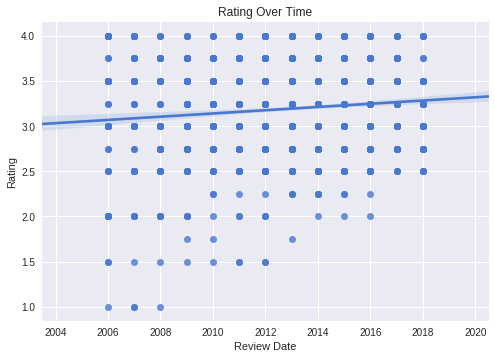

In [0]:
sns.regplot(x=choco_df['Review Date'], y=choco_df['Rating'])
plt.title('Rating Over Time')

### 2.2.7 Variable - Cocoa Percent

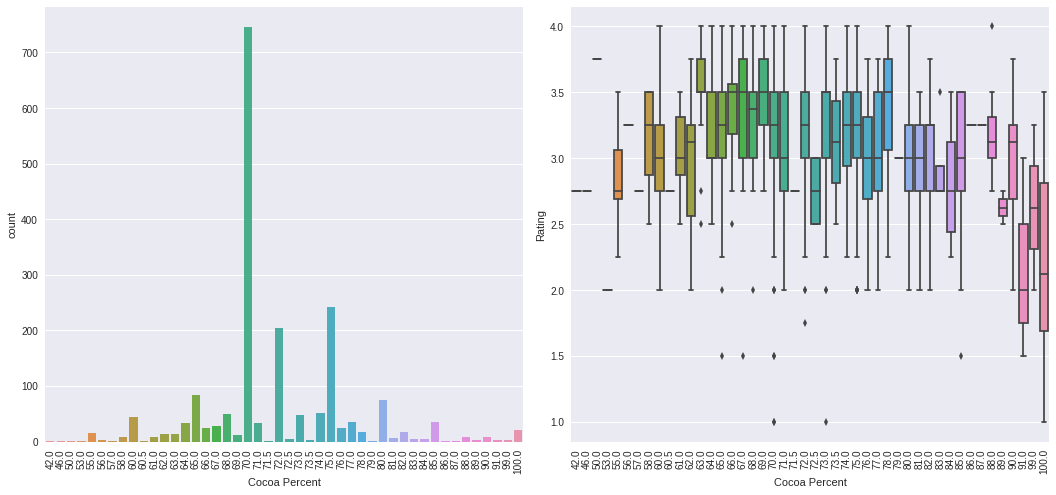

In [0]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.countplot(x='Cocoa Percent', data=choco_df, ax=ax[0],)
sns.boxplot(y='Rating', x='Cocoa Percent', data=choco_df, ax=ax[1])
plt.subplots_adjust(wspace=0.1)
ax[0].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='x', rotation=90)

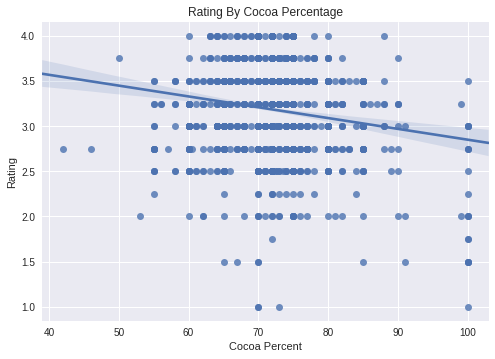

In [0]:
sns.regplot(x=choco_df['Cocoa Percent'], y=choco_df['Rating'])

plt.title('Rating By Cocoa Percentage')
plt.show()

### 2.2.8 Created variable - Domestic

In [0]:
# Create "Domestic feature" - Beans are from the same country where the chocolate bar is made in.
choco_df['domestic'] = np.where(choco_df['Company Location'] == choco_df['Broad Bean Origin'], 1, 0)
choco_df['domestic'].value_counts()

0    1716
1     221
Name: domestic, dtype: int64

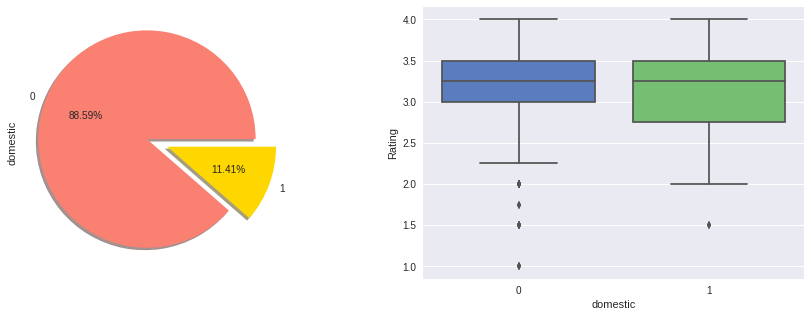

In [0]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.style.use('seaborn-muted')
parameters = {
    'autopct': '%.2f%%',
    'explode': (0.1, 0.1),
    'shadow': True,
    'colors': ['salmon', 'gold']
}
choco_df['domestic'].value_counts().plot(kind='pie', ax=ax[0], **parameters)
sns.boxplot(x='domestic',y='Rating',data=choco_df, ax=ax[1])

<Figure size 360x7200 with 0 Axes>

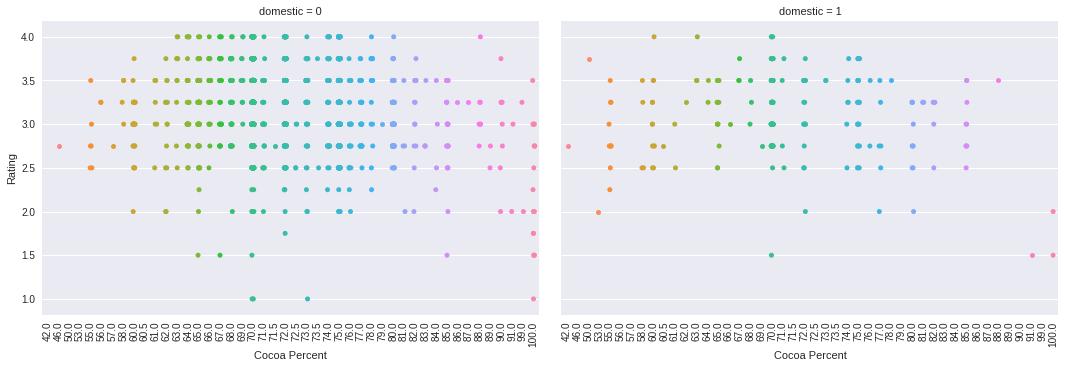

In [0]:
plt.figure(figsize=(5, 100))
g = sns.catplot(y='Rating',
             x='Cocoa Percent',
#              hue='domestic',
              col='domestic',
             data=choco_df, aspect=1.5)
#               kind='bar',))
#              palette='Set1'))
g.set_xticklabels(rotation=90)

# 3. Modelling

## 3.1 Data Preprocessing

In [0]:
choco_df_mod_s = pd.read_csv('choco_df_mod.csv', low_memory=False)

In [0]:
# Sorting by REF
choco_df_mod_s.sort_values(by=['REF'], inplace=True)

In [0]:
#Creating collumn for Bean Type NaN
choco_df_mod_s['bean_type_isnan'] = choco_df_mod_s['Bean Type'].isna().astype(int)
choco_df_mod_s.head()

,Company,Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin,bean_type_isnan
1427,Pralus,Trinidad,5,2006,75.0,France,3.50,Trinitario,Trinidad,0
1424,Pralus,"Madagascar, Nosy Be Isle.",5,2006,75.0,France,3.75,Criollo,Madagascar,0
948,Jacque Torres,Trinatario Treasure,5,2006,71.0,U.S.A.,2.00,Trinitario,Ghana,0
1425,Pralus,Sao Tome & Principe,5,2006,75.0,France,3.50,Forastero,Sao Tome & Principe,0
1270,Neuhaus (Callebaut),West Africa,15,2006,73.0,Belgium,2.00,Forastero,West Africa,0


In [0]:
cont_cols = [
    'REF',
    'Review Date',
    'Cocoa Percent',
]

cat_cols = [
    'Company',
    'Bean Origin or Bar Name',
    'Company Location',
    'Bean Type',
    'Broad Bean Origin',
    'bean_type_isnan',
]

# other_columns = [
#     'bean_type_isnan',
# ]
target_col = 'Rating'

In [0]:
train_data, test_data, train_labels, test_labels = (train_test_split
                                                    (choco_df_mod_s[cont_cols+cat_cols],
                                                     choco_df_mod_s[target_col],
                                                     test_size=0.2,
                                                     shuffle=False,))

In [0]:
[x.shape for x in (train_data, test_data, train_labels, test_labels)]

[(1549, 9), (388, 9), (1549,), (388,)]

In [0]:
train_data.tail(3)

,REF,Review Date,Cocoa Percent,Company,Bean Origin or Bar Name,Company Location,Bean Type,Broad Bean Origin,bean_type_isnan
551,1708,2016,75.0,Dark Forest,Bolivia,U.S.A.,NaN,Bolivia,1
1733,1708,2015,70.0,Szanto Tibor,"Ben Tre, Mekong Delta",Hungary,Trinitario,Vietnam,0
878,1712,2016,66.0,Hogarth,Gran Blanco,New Zealand,Criollo,Peru,0


In [0]:
test_data.head(3)

,REF,Review Date,Cocoa Percent,Company,Bean Origin or Bar Name,Company Location,Bean Type,Broad Bean Origin,bean_type_isnan
876,1712,2016,75.0,Hogarth,Conacado,New Zealand,Trinitario,Dominican Republic,0
879,1712,2016,72.0,Hogarth,Carenero Superior,New Zealand,Trinitario,Venezuela,0
877,1712,2016,70.0,Hogarth,Akesson's Estate,New Zealand,Trinitario,Madagascar,0


In [0]:
mode = train_data['Bean Type'].mode()
mode[0]

'Trinitario'

In [0]:
train_data['Bean Type'].fillna((mode[0]), inplace=True)
test_data['Bean Type'].fillna((mode[0]), inplace=True)

In [0]:
def cats_fit_transform(df, cat_cols):
    df = df.copy()
    cat_features_map = {}
    df[cat_cols] = df[cat_cols].astype("category")
    for cat_col in cat_cols:
        cat_features_map[cat_col] = dict(enumerate(df[cat_col].cat.categories, start=1))
        df[cat_col] = df[cat_col].cat.codes + 1
    return df, cat_features_map


def cats_transform(df, cat_features_map):
    df = df.copy()
    for cat_col in cat_features_map:
        df[cat_col] = df[cat_col].map(
            {value: key for key, value in cat_features_map[cat_col].items()}
        )
        df[cat_col].fillna(value=0, inplace=True)
        df[cat_col].astype(int)
    return df


def conts_fit_transform(df, cont_cols):
    df = df.copy()
    cont_features_map = {}
    df[cont_cols] = df[cont_cols].astype(float)
    for cont_col in cont_cols:
        cont_features_map[cont_col] = {
            "mean": df[cont_col].mean(),
            "std": df[cont_col].std(),
        }
        df[cont_col] = (
            df[cont_col] - cont_features_map[cont_col]["mean"]
        ) / cont_features_map[cont_col]["std"]
    return df, cont_features_map


def conts_transform(df, cont_features_map):
    df = df.copy()
    for cont_col in cont_features_map:
        df[cont_col] = (
            df[cont_col] - cont_features_map[cont_col]["mean"]
        ) / cont_features_map[cont_col]["std"]
    return df

In [0]:
train_data, cat_features_map = cats_fit_transform(train_data, cat_cols)

In [0]:
test_data = cats_transform(test_data, cat_features_map)

In [0]:
train_data, cont_features_map = conts_fit_transform(train_data, cont_cols)

In [0]:
test_data = conts_transform(test_data, cont_features_map)

In [0]:
with open(TEMP_DIR/'cat_features_map.pkl', 'wb') as f:
    pickle.dump(cat_features_map, f, pickle.HIGHEST_PROTOCOL)

In [0]:
with open(TEMP_DIR/'cont_features_map.pkl', 'wb') as f:
    pickle.dump(cont_features_map, f, pickle.HIGHEST_PROTOCOL)

In [0]:
cat_feature_dims = {cat_col: len(np.unique(train_data[cat_col])) + 2 for cat_col in cat_cols}

In [0]:
cat_feature_dims

{'Company': 347,
 'Bean Origin or Bar Name': 891,
 'Company Location': 55,
 'Bean Type': 36,
 'Broad Bean Origin': 95,
 'bean_type_isnan': 4}

## 3.2 RandomForestRegressor() using RandomizedSearchCV(

In [0]:
rfr_rs = RandomizedSearchCV(
    estimator=RandomForestRegressor(),
    param_distributions={
        "n_estimators": np.arange(10, 500),
        "min_samples_leaf": np.arange(1, 100),
        "max_depth": np.arange(1, 100),
        "max_features": ['sqrt', 'log2', 0.1],
    },
    n_iter=100,
    cv=5,
    n_jobs=-1,
    verbose=1,
)


In [0]:
rfr_rs.fit(train_data, train_labels)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   32.4s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': array([ 10,  11, ..., 498, 499]), 'min_samples_leaf': array([ 1,  2, ..., 98, 99]), 'max_depth': array([ 1,  2, ..., 98, 99]), 'max_features': ['sqrt', 'log2', 0.1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [0]:
joblib.dump(rfr_rs, str(TEMP_DIR/'rfr_rs.pkl'))
rfr_rs = joblib.load(str(TEMP_DIR/'rfr_rs.pkl'))

In [0]:
rfr_rs.best_params_

{'n_estimators': 122,
 'min_samples_leaf': 9,
 'max_features': 'sqrt',
 'max_depth': 8}

In [0]:
rfr_rs.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=9, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=122, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [0]:
pred_train_rfr_rs = rfr_rs.predict(train_data)

In [0]:
pred_test_rfr_rs = rfr_rs.predict(test_data)

In [0]:
test_metrics = pd.DataFrame(columns = ['RMSE'])

In [0]:
test_rmse_rfr_rs = np.sqrt(mean_squared_error(test_labels, pred_test_rfr_rs))
test_metrics.loc['RandomForest RS', 'RMSE'] = test_rmse_rfr_rs

In [0]:
print('Train RMSE:', np.sqrt(mean_squared_error(train_labels, pred_train_rfr_rs)))
print('Test RMSE:', test_rmse_rfr_rs)

Train RMSE: 0.40003505690303004
Test RMSE: 0.4015071034079027


In [0]:
def feature_importance_our(model, rmse_score_orig ):
    importances = {}
    for i in train_data.columns:
        train_data_cp = train_data.copy().reset_index(drop=True)
        train_data_cp[i] = train_data_cp[i].sample(frac=1).reset_index(drop=True)
        predictions = model.predict(train_data_cp)
        rmse_score = np.sqrt(mean_squared_error(np.array(train_labels), predictions))
        importances[i] = rmse_score - rmse_score_orig
    
    sum_importances = sum(importances.values())
    for i,j in importances.items():
        importances[i] = j / sum_importances
        
    return importances

In [0]:
# Feature importance our function
feat_imp_our_rs = feature_importance_our(rfr_rs, np.sqrt(mean_squared_error(train_labels, pred_train_rfr_rs)))

In [0]:
# Feature importance buil-in SKLEARN function
feat_importance_rf = (pd.DataFrame(rfr_rs.best_estimator_.feature_importances_,
                                    index=train_data.columns,
                                    columns=['importance']).sort_values('importance',ascending=False))

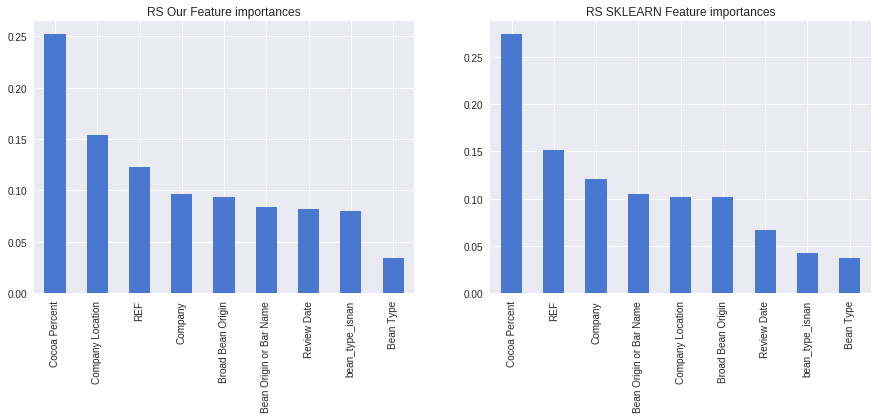

In [0]:
f,axes = plt.subplots(1, 2, figsize=(15,5))
pd.DataFrame(feat_imp_our_rs, index=["importance"]).T.sort_values("importance",ascending=False).plot(kind="bar",
                                                                               legend=False,
                                                                               ax=axes[0],
                                                                                title="RS Our Feature importances")
feat_importance_rf.plot(kind='bar',ax=axes[1], legend=False, title='RS SKLEARN Feature importances')

## 3.2 RandomForestRegressor() using GridSearchCV(

In [0]:
rfr_gs = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={
        "n_estimators": np.linspace(10, 500, 3).astype(int),
        "min_samples_leaf": np.linspace(1, 10, 3).astype(int),
        "max_depth": np.linspace(10, 100, 3).astype(int),
        "max_features": ['sqrt', 'log2', 0.1],
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [0]:
rfr_gs.fit(train_data, train_labels)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:   18.6s
/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': array([ 10, 255, 500]), 'min_samples_leaf': array([ 1,  5, 10]), 'max_depth': array([ 10,  55, 100]), 'max_features': ['sqrt', 'log2', 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [0]:
joblib.dump(rfr_gs, str(TEMP_DIR/'rfr_gs.pkl'))
rfr_gs = joblib.load(str(TEMP_DIR/'rfr_gs.pkl'))

In [0]:
rfr_gs.best_params_

{'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 5,
 'n_estimators': 500}

In [0]:
pred_train_rfr_gs = rfr_gs.predict(train_data)

In [0]:
pred_test_rfr_gs = rfr_gs.predict(test_data)

In [0]:
test_rmse_rfr_gs = np.sqrt(mean_squared_error(test_labels, pred_test_rfr_gs))
test_metrics.loc['RandomForest GS', 'RMSE'] = test_rmse_rfr_gs

In [0]:
print('Train RMSE:', np.sqrt(mean_squared_error(train_labels, pred_train_rfr_gs)))
print('Test RMSE:', np.sqrt(mean_squared_error(test_labels, pred_test_rfr_gs)))

Train RMSE: 0.3589043780920153
Test RMSE: 0.39988536512656525


In [0]:
# Feature importance our function
feat_imp_our_gs = feature_importance_our(rfr_gs, np.sqrt(mean_squared_error(train_labels, pred_train_rfr_gs)))

In [0]:
# Feature importance SKLEARN
feat_importance_gs = (pd.DataFrame(rfr_gs.best_estimator_.feature_importances_,
                                    index=train_data.columns,
                                    columns=['importance']).sort_values('importance', ascending=False))

(<matplotlib.axes._subplots.AxesSubplot at 0x7fda12f98b38>,)

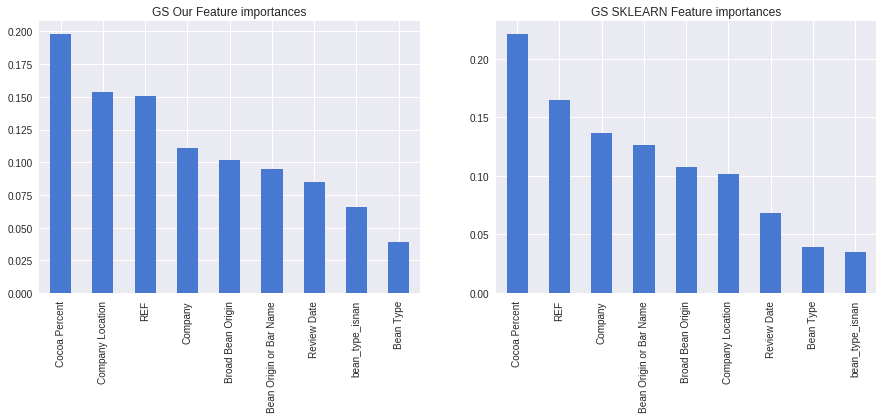

In [0]:
f,axes = plt.subplots(1, 2, figsize=(15,5))
pd.DataFrame(feat_imp_our_gs, index=["importance"]).T.sort_values("importance",ascending=False).plot(kind="bar",
                                                                               legend=False,
                                                                               ax=axes[0],
                                                                               title="GS Our Feature importances")
(feat_importance_gs.plot(kind='bar',
                         ax=axes[1], 
                         legend=False,
                         title='GS SKLEARN Feature importances'),)

## 3.3 RandomForestRegressor() using LGBMRegressorCV(

In [0]:
rs_lgbmr = RandomizedSearchCV(
    estimator=lgb.LGBMRegressor(n_jobs=1),
    param_distributions={
        'lgbmr__num_leaves': np.arange(10, 1000),
        'lgbmr__min_data_in_leaf': np.arange(5, 1000),
        'lgbmr__max_bin': np.arange(10, 100),
        'lgbmr__learning_rate': np.geomspace(1e-4, 1, 10),
        'lgbmr__n_estimators': np.arange(1, 1000),
        'lgbmr__boosting_type': ['gbdt', 'dart', 'goss'],
        'lgbmr__max_depth': np.arange(1, 1000),
    },
    n_iter=300,
    cv=3,
    n_jobs=-1,
    verbose=1,
)

In [0]:
rs_lgbmr.fit(train_data, train_labels)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:   20.2s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
          fit_params=None, iid='warn', n_iter=300, n_jobs=-1,
          param_distributions={'lgbmr__num_leaves': array([ 10,  11, ..., 998, 999]), 'lgbmr__min_data_in_leaf': array([  5,   6, ..., 998, 999]), 'lgbmr__max_bin': array([10, 11, ..., 98, 99]), 'lgbmr__learning_rate': array([1.00000e-04, 2.78256e-04, 7.74264e-04, 2.15443e-03, 5.99484e-03,
       1.66810e-02,...bmr__boosting_type': ['gbdt', 'dart', 'goss'], 'lgbmr__max_depth': array([  1,   2, ..., 998, 999])},
          pre_dispatch='2*n

In [0]:
joblib.dump(rs_lgbmr, str(TEMP_DIR/'rs_lgbmr.pkl'))
rs_lgbmr = joblib.load(str(TEMP_DIR/'rs_lgbmr.pkl'))

In [0]:
rs_lgbmr.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1,
       lgbmr__boosting_type='dart', lgbmr__learning_rate=0.0001,
       lgbmr__max_bin=20, lgbmr__max_depth=302,
       lgbmr__min_data_in_leaf=885, lgbmr__n_estimators=681,
       lgbmr__num_leaves=126, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [0]:
rs_lgbmr.best_params_

{'lgbmr__num_leaves': 126,
 'lgbmr__n_estimators': 681,
 'lgbmr__min_data_in_leaf': 885,
 'lgbmr__max_depth': 302,
 'lgbmr__max_bin': 20,
 'lgbmr__learning_rate': 0.0001,
 'lgbmr__boosting_type': 'dart'}

In [0]:
pred_train_rs_lgbmr = rs_lgbmr.predict(train_data)

In [0]:
pred_test_rs_lgbmr = rs_lgbmr.predict(test_data)

In [0]:
test_rmse_rs_lgbmr = np.sqrt(mean_squared_error(test_labels, pred_test_rs_lgbmr))
test_metrics.loc['LGBMRegressor RS', 'RMSE'] = test_rmse_rs_lgbmr

In [0]:
print('Train RMSE:', np.sqrt(mean_squared_error(train_labels, pred_train_rs_lgbmr)))
print('Test RMSE:', np.sqrt(mean_squared_error(test_labels, pred_test_rs_lgbmr)))

Train RMSE: 0.24440782268723263
Test RMSE: 0.41933125434667373


In [0]:
# Feature importance our function
feat_imp_our_rs_lgbmr = (feature_importance_our(rs_lgbmr,
                                                np.sqrt(mean_squared_error(train_labels,
                                                                           pred_train_rs_lgbmr))))

In [0]:
# Feature importance SKLEARN
feat_importance_rs_lgbmr = (pd.DataFrame(rs_lgbmr.best_estimator_.feature_importances_,
                                         index=train_data.columns,
                                         columns=['importance']).sort_values('importance', ascending=False))

(<matplotlib.axes._subplots.AxesSubplot at 0x7fda114de9b0>,)

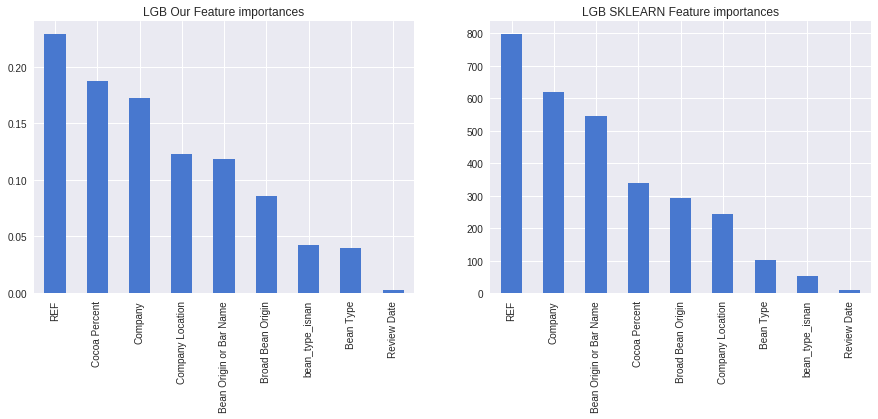

In [0]:
f,axes = plt.subplots(1, 2, figsize=(15,5))
pd.DataFrame(feat_imp_our_rs_lgbmr, index=["importance"]).T.sort_values("importance",ascending=False).plot(kind="bar",
                                                                               legend=False,
                                                                               ax=axes[0],
                                                                               title="LGB Our Feature importances")
(feat_importance_rs_lgbmr.plot(kind='bar',
                         ax=axes[1], 
                         legend=False,
                         title='LGB SKLEARN Feature importances'),)

## 3.4 NN Model

In [0]:
def make_model(
    input_shape,
    n_classes=1,
    layer_size=32,
    dropout_rate=0.0,
    n_layers=1,
    regularization=None,
    batch_norm=True,
):
    layers = [tf.keras.layers.InputLayer(input_shape=input_shape)]
    for _ in range(n_layers):
        if batch_norm:
            layers += [tf.keras.layers.BatchNormalization()]
        layers += [
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(
                layer_size,
                kernel_initializer="he_uniform",
                kernel_regularizer=regularization
                and tf.keras.regularizers.l1_l2(*regularization),
            ),
            tf.keras.layers.LeakyReLU(),
        ]
    layers += [tf.keras.layers.Dense(n_classes)]
    return tf.keras.Sequential(layers)

In [0]:
def plot_history(history, contains, skip=0):
    df = pd.DataFrame(history.history)
    df[list(df.filter(regex=contains))].iloc[skip:].plot()

### 3.4.1 NN Model - basic

In [0]:
nnr_model_1 = make_model(
    train_data.values.shape[1:],
    layer_size=32,
    dropout_rate=0.0,
    regularization=None,
    n_layers=3,
)

In [0]:
nnr_model_1.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=1e-3),
    loss=tf.keras.losses.mean_squared_error,
    metrics=[
        tf.keras.metrics.RootMeanSquaredError(),
    ]
)

In [0]:
nnr_model_1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_17 (Batc (None, 9)                 36        
_________________________________________________________________
dropout_17 (Dropout)         (None, 9)                 0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                320       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 32)                128       
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 32)               

In [0]:
nnr_model_1_history = nnr_model_1.fit(
    x=train_data.values,
    y=train_labels.values,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    verbose=0,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'nnr_model_1.h5'), save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=5),
        tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(log_dir=str(TEMP_DIR/'nnr_model_1_logs')),
    ],
)

In [0]:
nnr_model_1.evaluate(train_data, train_labels)

1549/1549 [==============================] - 0s 99us/sample - loss: 0.1741 - root_mean_squared_error: 0.4172


[0.17405892602661643, 0.4172037]

In [0]:
nnr_model_1.evaluate(test_data, test_labels)

388/388 [==============================] - 0s 292us/sample - loss: 0.2258 - root_mean_squared_error: 0.4752


[0.22580046997856848, 0.47518465]

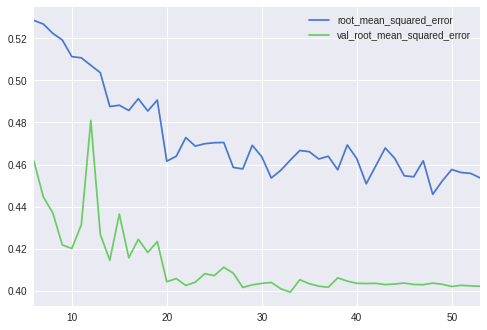

In [0]:
plot_history(nnr_model_1_history, 'root_mean_squared_error', skip=6)

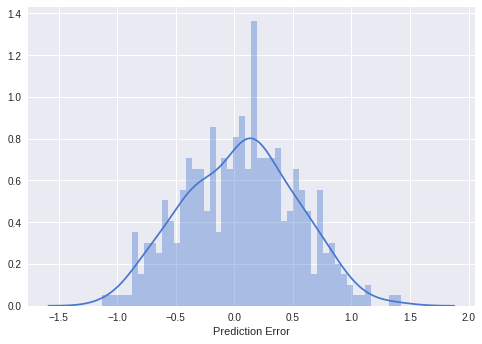

In [0]:
test_predictions_1 = nnr_model_1.predict(test_data).flatten()

sns.distplot(
    (test_predictions_1-test_labels),
    bins=50,
    axlabel="Prediction Error"
);

In [0]:
test_metrics.loc['NN_1', 'RMSE'] = np.sqrt(mean_squared_error(test_labels, test_predictions_1))

### 3.4.2 NN Model - adding dropout and regularization

In [0]:
nnr_model_2 = make_model(
    train_data.values.shape[1:],
    layer_size=32,
    dropout_rate=0.1,
    regularization=(1e-8, 1e-4),
    n_layers=3,
)

In [0]:
nnr_model_2.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=1e-3),
    loss=tf.keras.losses.mean_squared_error,
    metrics=[
        tf.keras.metrics.RootMeanSquaredError(),
    ]
)

In [0]:
nnr_model_2_history = nnr_model_2.fit(
    x=train_data.values,
    y=train_labels.values,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    verbose=0,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'nnr_model_2.h5'), save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=5),
        tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(log_dir=str(TEMP_DIR/'nnr_model_2_logs')),
    ],
)

In [0]:
nnr_model_2.evaluate(train_data, train_labels)

1549/1549 [==============================] - 0s 129us/sample - loss: 0.2150 - root_mean_squared_error: 0.4436


[0.21498642548235714, 0.443643]

In [0]:
nnr_model_2.evaluate(test_data, test_labels)

388/388 [==============================] - 0s 344us/sample - loss: 0.2336 - root_mean_squared_error: 0.4641


[0.23356476011349983, 0.46410927]

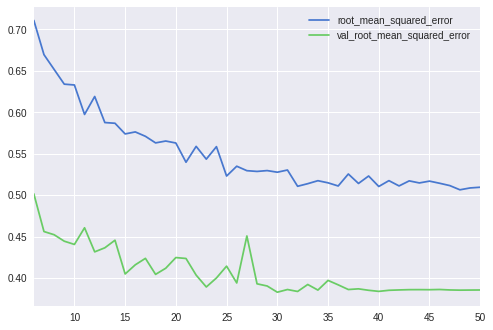

In [0]:
plot_history(nnr_model_2_history, 'root_mean_squared_error', skip=6)

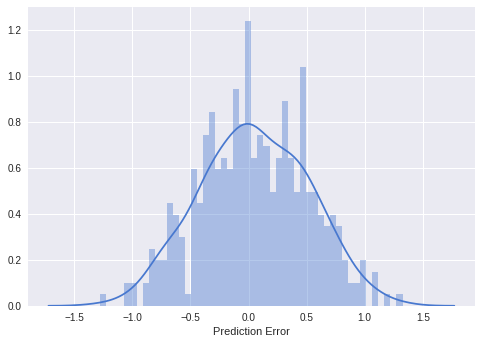

In [0]:
test_predictions_2 = nnr_model_2.predict(test_data).flatten()

sns.distplot(
    (test_predictions_2-test_labels),
    bins=50,
    axlabel="Prediction Error"
);

In [0]:
test_metrics.loc['NN_2', 'RMSE'] = np.sqrt(mean_squared_error(test_labels, test_predictions_2))

### 3.4.3 NN Model - only adding regularization

In [0]:
nnr_model_3 = make_model(
    train_data.values.shape[1:],
    layer_size=32,
    dropout_rate=0.0,
    regularization=(1e-8, 1e-4),
    n_layers=3,
)

In [0]:
nnr_model_3.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=1e-3),
    loss=tf.keras.losses.mean_squared_error,
    metrics=[
        tf.keras.metrics.RootMeanSquaredError(),
    ]
)

In [0]:
nnr_model_3_history = nnr_model_3.fit(
    x=train_data.values,
    y=train_labels.values,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    verbose=0,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'nnr_model_3.h5'), save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=5),
        tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(log_dir=str(TEMP_DIR/'nnr_model_3_logs')),
    ],
)


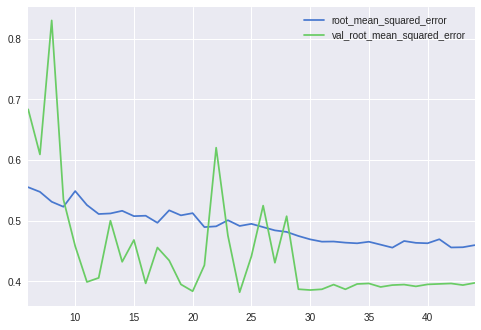

In [0]:
plot_history(nnr_model_3_history, 'root_mean_squared_error', skip=6)

In [0]:
nnr_model_3.evaluate(train_data, train_labels)

1549/1549 [==============================] - 0s 124us/sample - loss: 0.2019 - root_mean_squared_error: 0.4275


[0.2019224754739685, 0.4274505]

In [0]:
nnr_model_3.evaluate(test_data, test_labels)

388/388 [==============================] - 0s 294us/sample - loss: 0.2192 - root_mean_squared_error: 0.4473


[0.2192495822829684, 0.44725952]

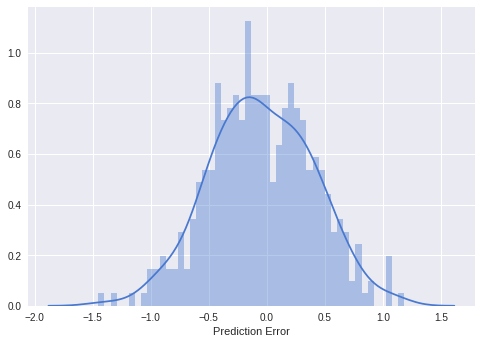

In [0]:
test_predictions_3 = nnr_model_3.predict(test_data).flatten()

sns.distplot(
    (test_predictions_3-test_labels),
    bins=50,
    axlabel="Prediction Error"
);

In [0]:
test_metrics.loc['NN_3', 'RMSE'] = np.sqrt(mean_squared_error(test_labels, test_predictions_3))

### 3.4.4 NN Model - increased number of layer size and adding dropout rate

In [0]:
nnr_model_4 = make_model(
    train_data.values.shape[1:],
    layer_size=64,
    dropout_rate=0.1,
    regularization=None,
    n_layers=3,
)

In [0]:
nnr_model_4.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=1e-3),
    loss=tf.keras.losses.mean_squared_error,
    metrics=[
        tf.keras.metrics.RootMeanSquaredError(),
    ]
)

In [0]:
nnr_model_4_history = nnr_model_4.fit(
    x=train_data.values,
    y=train_labels.values,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    verbose=0,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'nnr_model_4.h5'), save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=5),
        tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(log_dir=str(TEMP_DIR/'nnr_model_4_logs')),
    ],
)


In [0]:
nnr_model_4.evaluate(train_data, train_labels)

1549/1549 [==============================] - 0s 109us/sample - loss: 0.1906 - root_mean_squared_error: 0.4365


[0.1905563097709298, 0.43652758]

In [0]:
nnr_model_4.evaluate(test_data, test_labels)

388/388 [==============================] - 0s 298us/sample - loss: 0.1991 - root_mean_squared_error: 0.4462


[0.19906744529906006, 0.44616973]

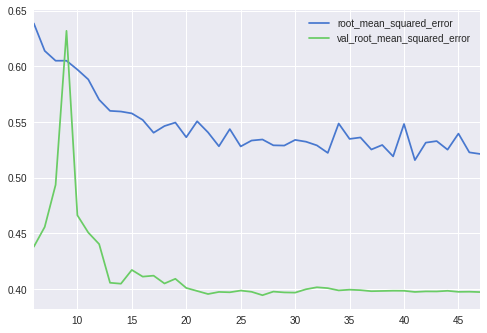

In [0]:
plot_history(nnr_model_4_history, 'root_mean_squared_error', skip=6)

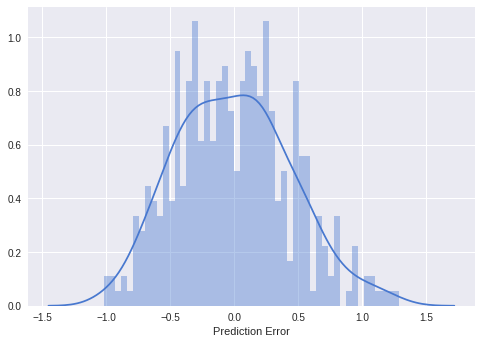

In [0]:
test_predictions_4 = nnr_model_4.predict(test_data).flatten()

sns.distplot(
    (test_predictions_4-test_labels),
    bins=50,
    axlabel="Prediction Error"
);

In [0]:
test_metrics.loc['NN_4', 'RMSE'] = np.sqrt(mean_squared_error(test_labels, test_predictions_4))

## 3.5 NN Model using embedings

In [0]:
def make_embedding_model(
    cat_feature_dims,
    n_cont_features,
    n_classes=1,
    layer_size=32,
    dropout_rate=0.0,
    regularization=None,
    n_layers=1,
    batch_norm=True,
):

    inputs = []
    embeddings = []
    for cat_feature_dim in cat_feature_dims.values():
        x = tf.keras.layers.Input(shape=(1,))
        inputs.append(x)
        x = tf.keras.layers.Embedding(
            cat_feature_dim, np.sqrt(cat_feature_dim).astype(int) + 1, input_length=1
        )(x)
        x = tf.keras.layers.Flatten()(x)
        embeddings.append(x)

    cont_inputs = tf.keras.layers.Input(shape=(n_cont_features,))
    inputs.append(cont_inputs)
    embeddings.append(cont_inputs)

    x = tf.keras.layers.Concatenate()(embeddings)

    for _ in range(n_layers):
        if batch_norm:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        x = tf.keras.layers.Dense(
            layer_size,
            kernel_initializer="he_uniform",
            kernel_regularizer=regularization and tf.keras.regularizers.l1_l2(*regularization),
        )(x)
        x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Dense(n_classes)(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

In [0]:
embedding_model = make_embedding_model(
    cat_feature_dims,
    len(cont_cols),
    n_classes=1,
    layer_size=64,
    dropout_rate=0.0,
    regularization=None,
    n_layers=3,
)

In [0]:
embedding_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=1e-3),
    loss=tf.keras.losses.mean_squared_error,
    metrics=[
        tf.keras.metrics.RootMeanSquaredError(),
    ]
)

In [0]:
emb_train_data = [train_data[x] for x in train_data[cat_cols]] + [train_data[cont_cols]]

In [0]:
embedding_model_history = embedding_model.fit(
    emb_train_data,
    train_labels,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    verbose=0,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'embedding_model.h5'), save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=5),
        tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(log_dir=str(TEMP_DIR/'embedding_model_logs')),
    ]
)

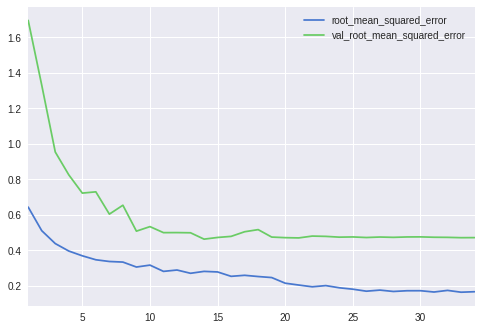

In [0]:
plot_history(embedding_model_history, 'root_mean_squared_error', skip=1)

In [0]:
emb_test_data = [test_data[x] for x in test_data[cat_cols]] + [test_data[cont_cols]]

In [0]:
embedding_model.evaluate(emb_train_data, train_labels)

1549/1549 [==============================] - 0s 123us/sample - loss: 0.0998 - root_mean_squared_error: 0.3160


[0.09983951329049794, 0.31597394]

In [0]:
embedding_model.evaluate(emb_test_data, test_labels)

388/388 [==============================] - 0s 380us/sample - loss: 0.2282 - root_mean_squared_error: 0.4777


[0.22818070619376665, 0.47768265]

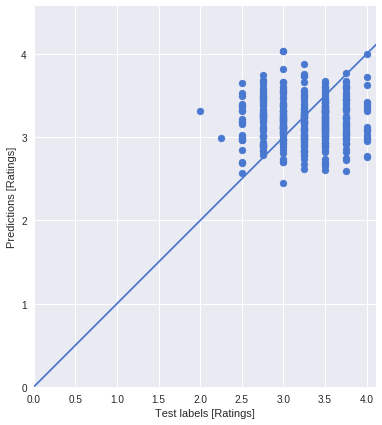

In [0]:
test_predictions_emb = embedding_model.predict(emb_test_data).flatten()

plt.figure(figsize=(7,7));
plt.scatter(test_labels, test_predictions_emb)
plt.xlabel('Test labels [Ratings]')
plt.ylabel('Predictions [Ratings]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
plt.plot([-100, 100], [-100, 100]);

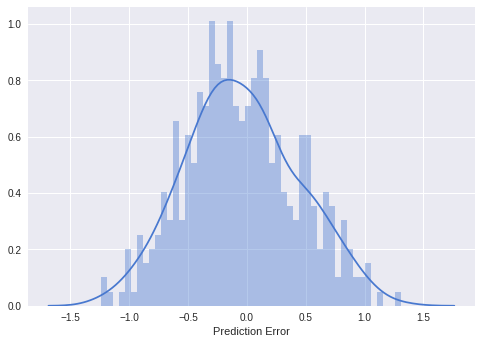

In [0]:
test_predictions_emb = embedding_model.predict(emb_test_data).flatten()

sns.distplot(
    (test_predictions_emb-test_labels),
    bins=50,
    axlabel="Prediction Error"
);

In [0]:
test_metrics.loc['NN_Emb', 'RMSE'] = np.sqrt(mean_squared_error(test_labels, test_predictions_emb))

## 3.6 NN Model - using HP tuning

In [0]:
def make_opt_model(
    layer_size,
    n_layers,
    input_shape,
    optimizer=keras.optimizers.Adam,
    lr=1e-3,
    dropout=0,
    l1_reg=0,
    l2_reg=0,
):
    for i in range(n_layers):
        layers = []
        layers += [
            keras.layers.BatchNormalization() if i else keras.layers.BatchNormalization(input_shape=input_shape),
            keras.layers.Dense(
                layer_size,
                activation=tf.nn.leaky_relu,
                kernel_initializer="he_uniform",
                kernel_regularizer=keras.regularizers.l1_l2(l1_reg, l2_reg),
            ),
            keras.layers.Dropout(dropout),
        ]
    layers += [keras.layers.Dense(1)]
    model = keras.Sequential(layers)
    model.compile(
        optimizer=optimizer(lr=lr),
        loss=tf.keras.losses.mean_squared_error,
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    return model


In [0]:
default_parameters = [16, 1, keras.optimizers.RMSprop, 1e-5, 0., 1e-8, 1e-8, 2]

In [0]:
dimensions = [
    skopt.space.Integer(low=16, high=512, name='layer_size'),
    skopt.space.Integer(low=1, high=5, name='n_layers'),
    skopt.space.Categorical([
         keras.optimizers.Adam,
         keras.optimizers.Nadam,
        keras.optimizers.RMSprop,
    ], name='optimizer'),
    skopt.space.Real(low=1e-5, high=1e-3, prior='log-uniform', name='lr'),
    skopt.space.Real(low=0., high=0.5, name='dropout'),
    skopt.space.Real(low=1e-8, high=1e-2, prior='log-uniform', name='l1_reg'),
    skopt.space.Real(low=1e-8, high=1e-2, prior='log-uniform', name='l2_reg'),
    skopt.space.Integer(low=2, high=20, name='patience'),
]

In [0]:
best_rmse = 3
best_model_arch_path = str(TEMP_DIR/'best_model.json')
best_model_weights_path = str(TEMP_DIR/'best_model.h5')

In [0]:
input_shape = train_data.shape[1:]

@skopt.utils.use_named_args(dimensions=dimensions)
def fitness(
    layer_size,
    n_layers,
    optimizer,
    lr,
    dropout,
    l1_reg,
    l2_reg,
    patience,
):
    model = make_opt_model(
        layer_size,
        n_layers,
        input_shape,
        optimizer,
        lr,
        dropout,
        l1_reg,
        l2_reg,
    )

    history = model.fit(
        x=train_data.values,
        y=train_labels.values,
        validation_split=0.2,
        epochs=300,
        verbose=0,
        batch_size=32,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=patience * 3, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(patience=patience),
        ],   
    )

    rmse = min(history.history['root_mean_squared_error'])

    print("RMSE: {0}\n".format(rmse))
    global best_rmse

    if rmse < best_rmse:
        print('Best model'.center(80, '-'))
        print("RMSE: {0}".format(rmse))
        print(
            layer_size,
            n_layers,
            optimizer,
            lr,
            dropout,
            l1_reg,
            l2_reg,
            patience,
        )
        model.save_weights(best_model_weights_path)
        with open(best_model_arch_path, "w") as f:
            f.write(model.to_json())
        best_rmse = rmse

    del model

    keras.backend.clear_session()

    return -rmse

In [0]:
search_result = skopt.gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func='EI',
    n_calls=20,     
    x0=default_parameters,
)

RMSE: 1.3451412916183472

-----------------------------------Best model-----------------------------------
RMSE: 1.3451412916183472
16 1 <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'> 1e-05 0.0 1e-08 1e-08 2
RMSE: 1.1731436252593994

-----------------------------------Best model-----------------------------------
RMSE: 1.1731436252593994
60 1 <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'> 1.679202143534387e-05 0.20636780504988128 0.0016166113413366029 2.4483265660940128e-05 15
RMSE: 0.4892241954803467

-----------------------------------Best model-----------------------------------
RMSE: 0.4892241954803467
335 2 <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'> 0.000363672532744999 0.3529242637589894 3.4448704554025887e-06 8.235957785323996e-05 18
RMSE: 0.6158593893051147

RMSE: 1.1366634368896484

RMSE: 0.8139725923538208

RMSE: 0.4733690619468689

-----------------------------------Best model-----------------------------------
RMSE: 0.473369061946

In [0]:
with open(best_model_arch_path, 'r') as f:
    model = keras.models.model_from_json(f.read(), custom_objects={'leaky_relu': tf.nn.leaky_relu})

In [0]:
model.load_weights(best_model_weights_path)

In [0]:
test_predictions_model = model.predict(test_data.values)

In [0]:
print('Test RMSE:', np.sqrt(mean_squared_error(test_labels, test_predictions_model)))

Test RMSE: 0.40146835532970016


In [0]:
test_metrics.loc['NN_Tuned', 'RMSE'] = np.sqrt(mean_squared_error(test_labels, test_predictions_model))

## 4. Summary

In [0]:
test_metrics

,RMSE
RandomForest RS,0.401507
RandomForest GS,0.399885
LGBMRegressor RS,0.419331
NN_1,0.475185
NN_2,0.464109
NN_3,0.44726
NN_4,0.44617
NN_Emb,0.477683
NN_Tuned,0.401468
